In [1]:
import sys
sys.path.insert(0, '..')

import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from diaphanous import show

show('<h1>Overview of CyberTipline Reports</h1>')
show(
    """
    Per <a href="https://www.law.cornell.edu/uscode/text/18/2258A">18 US Code
    §2258A</a>, a number of activities related to the sexual exploitation of
    children must be reported to the National Center for Missing and Exploited
    Children or NCMEC. The following overview of the reports is based on NCMEC's
    <a
    href="https://www.missingkids.org/content/dam/missingkids/pdfs/OJJDP-NCMEC-Transparency_2022-Calendar-Year.pdf">2022
    Report to the Office of Juvenile Justice and Delinquency Prevention</a>.
    """
)

show('<h2>Number of Reports</h2>')
show(
    """
    NCMEC started its CyberTipline in 1998. Since then, the number of reports
    has increased significantly, doubling in many but not nearly all years.
    NCMEC has characterized this growth as exponential in the above transparency
    report. Alas, I am not convinced that is the case. As the figure below
    shows, a piecewise linear fit over 1998–2014 and 2015–2022 seems more
    accurate.
    """
)
reports_per_year = (
    pd.read_csv(
        '../data/ocse-reports-per-year.csv',
        thousands=',',
        index_col='year'
    )
    .sort_index(ascending=True)
)

part = reports_per_year.loc[reports_per_year.index < 2014]['reports']
fit = flf = np.polyfit(part.index, part, 1)
reports_per_year.loc[reports_per_year.index < 2014, 'fit'] = np.poly1d(fit)(part.index)

part = reports_per_year.loc[reports_per_year.index >= 2014]['reports']
fit = slf = np.polyfit(part.index, part, 1)
reports_per_year.loc[reports_per_year.index >= 2014, 'fit'] = np.poly1d(fit)(part.index)

reports = reports_per_year['reports']
log_reports = np.log(reports)
fit = np.polyfit(log_reports.index, log_reports, 1)
reports_per_year['exp_fit'] = [math.exp(fit[1] + fit[0] * x) for x in log_reports.index]

fit = np.polyfit(log_reports.index, log_reports, 1, w=np.sqrt(reports))
reports_per_year['exp_fitter'] = [math.exp(fit[1] + fit[0] * x) for x in log_reports.index]

r2015 = reports_per_year.loc[2015, "reports"]
reports_per_year['Δ'] = reports - reports.shift()
reports_per_year['Δ%'] = (reports - reports.shift()) / r2015 * 100


In [2]:
show("<h3>Mean Square Error of Fits</h3>")
mean_square_error = pd.Series({
    'fit': (reports_per_year['reports'] - reports_per_year['fit']).pow(2).mean(),
    'exp_fit': (reports_per_year['reports'] - reports_per_year['exp_fit']).pow(2).mean(),
    'exp_fitter': (reports_per_year['reports'] - reports_per_year['exp_fitter']).pow(2).mean(),
}).sort_values(ascending=True)
mean_square_error.name = 'mean_square_error'
mean_square_error = mean_square_error.to_frame()
mean_square_error['factor'] = mean_square_error['mean_square_error'] / mean_square_error.loc['fit', 'mean_square_error']

show(mean_square_error)

,mean_square_error,factor
fit,"1,015,329,458,209.4",1.000
exp_fitter,"6,579,294,254,831.9",6.480
exp_fit,"15,244,862,404,780.1",15.015


In [3]:
show("<h3>Equations for Piecewise-Linear Fit</h3>")
show(f"""
    <p>The <em>first</em> line of the piecewise linear fit is:</p>

    <p style="margin: 0 0 0 2em;">
    <var>y</var>&nbsp;=&nbsp;{flf[0]:,.1f}&nbsp;<var>x</var>&nbsp;-&nbsp;{abs(flf[1]):,.1f}
    </p>

    <p>That's a growth of 27.2 thousand CyberTipline reports per year!</p>
""")
show(f"""
    <p>The <em>second</em> line of the piecewise linear fit is:</p>

    <p style="margin: 0 0 0 2em;">
    <var>y</var>&nbsp;=&nbsp;{slf[0]:,.1f}&nbsp;<var>x</var>&nbsp;-&nbsp;{abs(slf[1]):,.1f}
    </p>

    <p>That's a growth of 3.9 million CyberTipline reports per year!</p>

    <p>Meanwhile, the magnitude of the constant term isn't particularly interesting.
    The line intersects the x-axis close to 2014, which means that it intersects
    the y-axis at close to -2014 * slope or -7.9 billion.</p>
""")

,reports,fit,exp_fit,exp_fitter,Δ,Δ%
year,,,,,,
2005,"70,768","126,327.4","73,792.7","374,213.6","-41,249.0",-0.9367
2008,"102,029","208,287.9","217,279.4","831,824.1","-3,232.0",-0.0734
2019,"16,987,361","19,853,153.2","11,394,710.4","15,561,161.0","-1,475,061.0",-33.4963


,Δ,Δ%
count,9.00,9.00
mean,"3,900,477.44",88.57
std,"2,925,530.59",66.43
min,"-1,475,061.00",-33.50
25%,"2,661,348.00",60.43
50%,"3,894,266.00",88.43
75%,"4,763,724.00",108.18
max,"8,247,669.00",187.29


,reports,fit,Δ,Δ%,z_score
year,,,,,
2015,"4,403,657","4,140,207.7","3,297,586.0",74.9,-0.20608
2016,"8,297,923","8,068,444.1","3,894,266.0",88.4,-0.00212
2017,"10,214,753","11,996,680.4","1,916,830.0",43.5,-0.67805
2018,"18,462,422","15,924,916.8","8,247,669.0",187.3,1.48595
2019,"16,987,361","19,853,153.2","-1,475,061.0",-33.5,-1.83746
2020,"21,751,085","23,781,389.6","4,763,724.0",108.2,0.29507
2021,"29,397,681","27,709,625.9","7,646,596.0",173.6,1.28049
2022,"32,059,029","31,637,862.3","2,661,348.0",60.4,-0.42356
2023,"36,210,368","35,566,098.7","4,151,339.0",94.3,0.08575


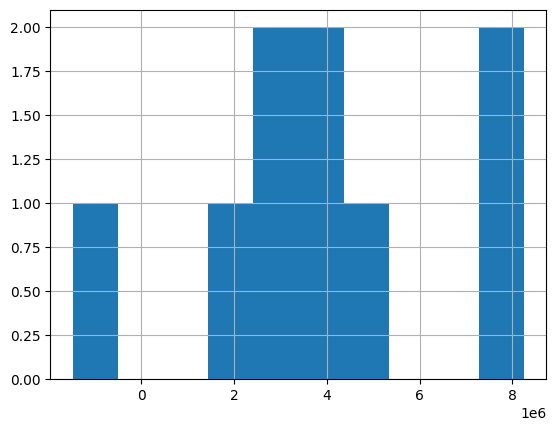

In [4]:
show("<h3>Year-Over-Year Growth</h3>")

show(reports_per_year[reports_per_year["Δ%"] < 0], caption="Years with negative growth")
after2014 = reports_per_year[reports_per_year.index > 2014].copy()
stats2014 = after2014[["Δ", "Δ%"]].describe()
after2014["z_score"] = (after2014["Δ"] - stats2014.loc["mean", "Δ"]) / stats2014.loc["std", "Δ"]
show(stats2014, caption="Yearly Growth 2015 Onward (Stats)")
show(after2014.drop(columns=["exp_fit", "exp_fitter"]), caption="Yearly Growth 2015 Onward (Data)")

show("<h4>Histogram of Yearly Growth Values</h4>")
show("""
     Histogram buckets cover the range of growth values from -1.5 to 8.2 million reports,
     with each bucket having between 0 and 2 (inclusive) hits.
""")
after2014["Δ"].hist()
None

,norm_msq_err,factor
lin,0.359,1.000
exp,0.772,2.147


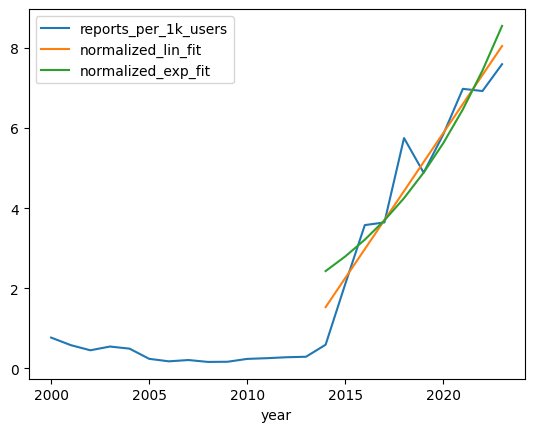

In [5]:
show("<h2>Reports Per 1,000 Social Media User Identities</h2>")

# Normalize reports by social media user identities
users = (
    pd.read_csv("../data/social-media-users.csv")
    .assign(users=lambda df: df["million_users"] * 1_000_000)
    .drop(columns="million_users")
    .astype({"users": int})
    .set_index("year")
)

user_reports = (
    users.join(reports)
    .assign(users_per_report=lambda df: df["users"] / df["reports"])
    .assign(reports_per_1k_users=lambda df: df["reports"] / df["users"] * 1_000)
)

# Merge into main data frame
reports_per_year["reports_per_1k_users"] = user_reports["reports_per_1k_users"]

# Partially fit that curve
points = reports_per_year[reports_per_year.index >= 2014]["reports_per_1k_users"]
user_linear_fit = np.polyfit(points.index, points, 1)
reports_per_year.loc[reports_per_year.index >= 2014, 'normalized_lin_fit'] = (
    np.poly1d(user_linear_fit)(points.index)
)

user_exp_fit = np.polyfit(points.index, np.log(points), 1, w=np.sqrt(points))
reports_per_year.loc[reports_per_year.index >= 2014, "normalized_exp_fit"] = [
    math.exp(user_exp_fit[1] + user_exp_fit[0] * x) for x in points.index
]

# Calculate mean square errors for last decade
tmp = reports_per_year[reports_per_year.index >= 2014]
norm_msq_err = pd.Series({
    'lin': (tmp['reports_per_1k_users'] - tmp['normalized_lin_fit']).pow(2).mean(),
    'exp': (tmp['reports_per_1k_users'] - tmp['normalized_exp_fit']).pow(2).mean(),
}).sort_values(ascending = True)
norm_msq_err.name = 'norm_msq_err'
norm_msq_err = norm_msq_err.to_frame()
norm_msq_err['factor'] = norm_msq_err['norm_msq_err'] / norm_msq_err.loc['lin', 'norm_msq_err']

show("""
     For reports per 1k users, a linear least squares fit still is a better fit
     than the weighted exponential. Calculation only considers last decade.
""")

show(norm_msq_err, caption="mean square error for fitting normalized report counts")

reports_per_year[["reports_per_1k_users", "normalized_lin_fit", "normalized_exp_fit"]].plot.line()

show("""
     Normalizing by social media user identities re-establishes human scale:
     There are between 0 and 8 reports for every 1,000 social media user identities.
     Alas, the number of reports nonetheless has been growing linearly since 2014.
""")

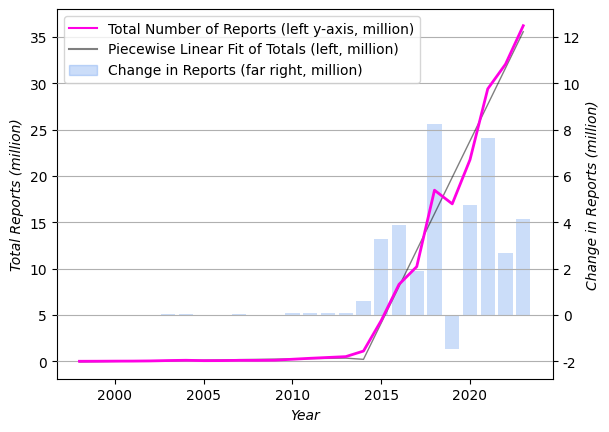

In [6]:
reports_and_best_fit = reports_per_year[['reports', 'fit', 'Δ']].rename(columns={
    'reports': 'Reports per Year',
    'fit': 'Piecewise Linear Fit',
    'Δ': 'Yearly Change',
})

reports_and_all_fits = reports_per_year.rename(columns={
    'reports': 'Reports per Year',
    'fit': 'Piecewise Linear Fit',
    'exp_fit': 'Exponential Fit',
    'exp_fitter': 'Weighted Exponential Fit',
}).drop(columns=['Δ%'])

FIT_COLOR = '#00000080'

def plot(ax, reports, scale = 'linear'):
    reports = reports.reset_index()

    has_change = 'Yearly Change' in reports.columns
    has_users = 'Reports Per 1k Users' in reports.columns

    main_columns = ['Reports per Year', 'Piecewise Linear Fit']
    if 'Exponential Fit' in reports.columns:
        main_columns += ['Exponential Fit', 'Weighted Exponential Fit']
    main_colors = ['#ff00e4', FIT_COLOR, '#3178ea', '#208020']

    for column, color in zip(main_columns, main_colors):
        ax.plot('year', column, color=color, data=reports)

    if has_change:
        ax2 = ax.twinx()
        ax2.bar('year', 'Yearly Change', color='#3178ea40', data=reports)
        ax2.set_ylim(-2_750_000, 13_200_000)
        #ax2.set_ylim(-1_675_000, 8_500_000)

    if has_change and not has_users:
        ax2.set_ylabel('Change in Reports (million)', fontstyle="italic")
        ax2.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

    if has_change and has_users:
        ax2.set_ylabel('Reports Per 1k Users (Change in Reports, million)', fontstyle="italic")
        ax2.set_yticklabels([
            '',
            '0 (-2)',
            '1 (0)',
            '2 (2)',
            '3 (4)',
            '4 (6)',
            '5 (8)',
            '6',
            '7',
        ])

    if has_users:
        ax3 = ax.twinx()
        ax3.plot('year', 'Reports Per 1k Users', color='#ff9600', data=reports)
        ax3.plot('year', 'normalized_lin_fit', color=FIT_COLOR, data=reports)
        ax3.set_ylim(-0.4, 7.6)
        ax3.set_yticklabels([])

    ax.set_xlabel('Year', fontstyle='italic')
    if scale == 'linear':
        ax.set_ylabel('Total Reports (million)', fontstyle='italic')
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
    else:
        ax.set_ylabel('Reports (Ten Thousands to Ten Millions)', fontstyle='italic')

    ax.grid(axis="y")
    if scale == 'linear':
        ax.set_ylim(
            top=52_000_000 if "Exponential Fit" in reports.columns else 38_000_000
        )
    else:
        ax.set_yscale('log')

    handles, labels = ax.get_legend_handles_labels()
    labels[0] = 'Total Number of Reports (left y-axis, million)'
    labels[1] = 'Piecewise Linear Fit of Totals (left, million)'
    if has_users:
        handles = [
            handles[0],
            mlines.Line2D([], [], color='#ff9600'),
        ]
        labels = [
            labels[0],
            'Reports Per 1k Social Media Users (right)',
        ]
    if has_change:
        handles = handles + [mpatches.Patch(color='#3178ea40')]
        labels = labels + ['Change in Reports (far right, million)']
    ax.legend(handles, labels)

    line = ax.get_lines()[0]
    line.set_linewidth(2)
    line.set_zorder(3)
    line = ax.get_lines()[1]
    line.set_linewidth(1)

    if has_users:
        line = ax3.get_lines()[0]
        line.set_linewidth(2)
        line.set_zorder(3)
        line = ax3.get_lines()[1]
        line.set_linewidth(1)

    ax.set_zorder((ax2.get_zorder() if has_change or has_users else 0) + 1)
    ax.set_frame_on(False)

fig, ax = plt.subplots()
plot(ax, reports_and_best_fit)
fig.savefig('../figure/reports.svg', format='svg')

/var/folders/qb/cntw4rqd7hb_2r_x93275q5w0000gn/T/ipykernel_28042/3369528837.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([


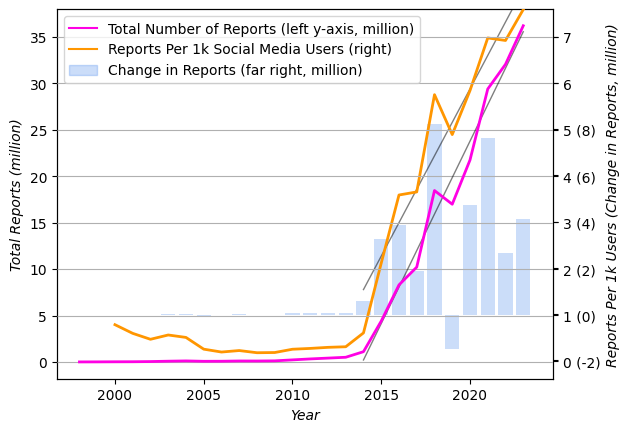

In [7]:
fig, ax = plt.subplots()
tmp = reports_per_year.copy()
tmp.loc[tmp.index < 2014, 'fit'] = None
tmp = tmp[['reports', 'fit', 'Δ', 'reports_per_1k_users', 'normalized_lin_fit']].rename(columns={
    'reports': 'Reports per Year',
    'fit': 'Piecewise Linear Fit',
    'Δ': 'Yearly Change',
    'reports_per_1k_users': 'Reports Per 1k Users',
})
plot(ax, tmp)
fig.savefig('../figure/reports-plus.svg', format='svg', bbox_inches='tight')

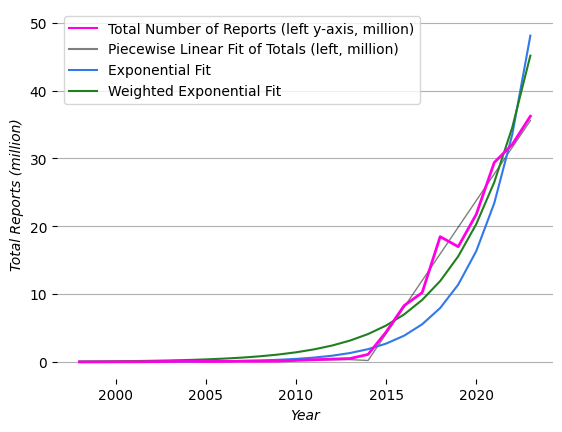

In [8]:
fig, ax = plt.subplots()
plot(ax, reports_and_all_fits)

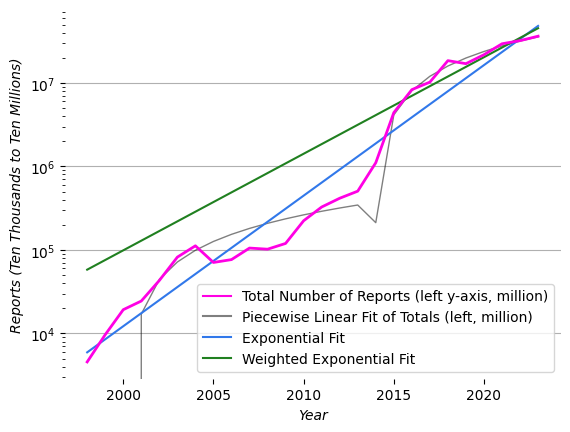

In [9]:
fig, ax = plt.subplots()
plot(ax, reports_and_all_fits, "log")

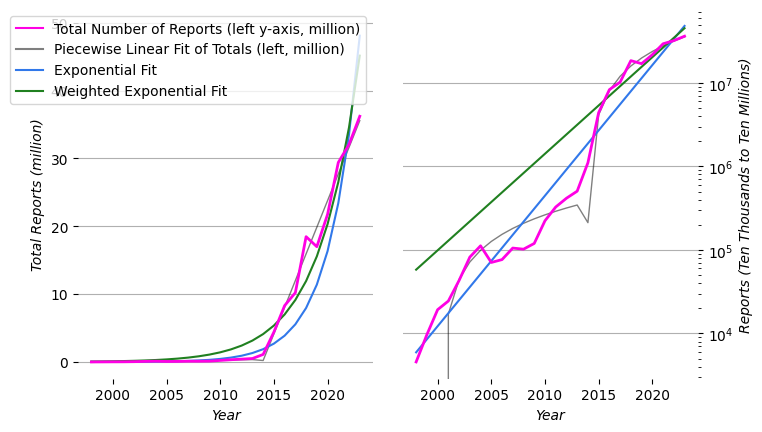

In [10]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=[8, 4.8],
    gridspec_kw=dict(wspace=0.1),
)

plot(ax1, reports_and_all_fits)
plot(ax2, reports_and_all_fits, 'log')

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.get_legend().remove()

In [11]:
contents = pd.read_csv('../data/ocse-report-contents.csv', thousands=',')

totals = (
    contents[(contents['category'] == 'reports') & (contents['label'] == 'total')]
    .drop(columns=['category', 'label'])
    .set_index('year')['quantity']
)

prep = (
    contents[contents['category'] == 'kind of exploitation']
    .drop(columns='category')
    .pivot(index='label', columns='year', values='quantity')
)
assert totals.equals(prep.sum())

violations = pd.DataFrame(index=prep.index)
for year, entries in prep.items():
    violations[year] = entries
    violations[f'{year} %'] = entries / totals[year] * 100

show('<h2>Reported Activities</h2>')
show(
    """
    A number of activities related to the sexual exploitation of children must
    be reported. But in practice almost all reports concern child pornography,
    i.e., <em>child sexual abuse material</em> (CSAM).
    """
)

def percentage_columns(df: pd.DataFrame) -> list[str]:
    return [c for c in df.columns if isinstance(c, str) and '%' in c]

show(
    violations.sort_values(by=2023, ascending=False),
    caption='Reported Activities (in Descending Order for 2023)',
    highlight_columns=percentage_columns(violations),
    highlight_rows='child pornography',
)


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
label,,,,,,,,
child pornography,"21,669,264",99.62383,"29,309,106",99.69870,"31,901,234",99.50780,"35,925,098",99.21219
online enticement of children,"37,872",0.17412,"44,155",0.15020,"80,524",0.25117,"186,819",0.51593
obscene material sent to a child,"3,547",0.01631,"5,177",0.01761,"35,624",0.11112,"45,746",0.12633
child sexual molestation,"11,770",0.05411,"12,458",0.04238,"12,906",0.04026,"18,021",0.04977
child sex trafficking,"15,879",0.07300,"16,032",0.05453,"18,336",0.05719,"17,353",0.04792
misleading words/images online,"8,689",0.03995,"5,825",0.01981,"7,517",0.02345,"8,446",0.02332
misleading domain name,"3,109",0.01429,"3,304",0.01124,"1,948",0.00608,"6,883",0.01901
child sex tourism,955,0.00439,"1,624",0.00552,940,0.00293,"2,002",0.00553


In [12]:
pieces = (
    contents[contents['category'] == 'attachments']
    .drop(columns='category')
    .pivot(index='year', columns='label', values='quantity')
)

pieces['reports'] = totals
pieces['pieces'] = pieces['photos'] + pieces['videos']
pieces['unique pieces'] = pieces['unique photos'] + pieces['unique videos']
pieces['similar pieces'] = pieces['similar photos'] + pieces['similar videos']
pieces['π(⏵)'] = pieces['pieces'] / totals
pieces['π(⏴)'] = pieces['pieces'] / pieces['unique pieces']
pieces['π(⏴⏴)'] = pieces['pieces'] / pieces['similar pieces']
pieces = pieces[
    [
        'reports',
        'π(⏵)',
        'pieces',
        'π(⏴)',
        'unique pieces',
        'π(⏴⏴)',
        'similar pieces',
    ]
]

show('<h2>Report Attachments</h2>')
show(
    """
    <p>Each report may have one or more attachments or <em>pieces</em>.
    Commonly, a piece is a photo or video. NCMEC uses MD5 to determine unique
    pieces and PhotoDNA as well as Videntity to determine perceptually similar
    pieces.</p>

    <p>Given that <a
    href="https://marc-stevens.nl/research/papers/StLdW%20-%20Chosen-Prefix%20Collisions%20for%20MD5%20and%20Applications.pdf">chosen
    prefix attacks against MD5</a> have been practical for years now, it is
    deeply concerning that NCMEC claimed the opposite in 2023, stating that <a
    href="https://www.missingkids.org/content/dam/missingkids/pdfs/OJJDP-NCMEC-Transparency_2022-Calendar-Year.pdf">[i]mages
    that share the same MD5 hash are identical</a>. The organization would be
    well-advised to cease making such false claims and switch to a stronger
    cryptographic hash, such as SHA-3.</p>

    <p>In the table below, columns labeled with "π(...)" (for product) contain
    the multiplicative factors relating reports, unique pieces, and similar
    pieces with the number of pieces in the highlighted column. Clearly, the
    same CSAM pieces are reported over and over again.</p>
    """
)

show(
    pieces,
    caption='Reports vs Pieces',
    highlight_columns='pieces',
)


label,reports,π(⏵),pieces,π(⏴),unique pieces,π(⏴⏴),similar pieces
year,,,,,,,
2020,"21,751,085",3.00,"65,344,724",2.39,"27,333,171",4.62,"14,141,118"
2021,"29,397,681",2.88,"84,795,507",2.32,"36,625,281",3.85,"22,005,389"
2022,"32,059,029",2.72,"87,179,813",2.01,"43,399,901",3.21,"27,136,862"
2023,"36,210,368",2.88,"104,370,572",2.09,"49,979,320",3.10,"33,640,168"


In [13]:
pcounts = pieces['pieces']
fit = np.polyfit(pcounts.index, pcounts, 1)
show(f"Linear fit for piece counts: {fit[0]:,.1f} <var>x</var> - {abs(fit[1]):,.1f}")

In [14]:
overreports = (
    contents[contents['category'] == 'reports']
    .drop(columns='category')
    .pivot(index='year', columns='label', values='quantity')
)
overreports['π(⏴)'] = (
    overreports['total'] / overreports['with unique photos/videos']
)
overreports['π(⏴⏴)'] = (
    overreports['total'] / overreports['with similar photos/videos']
)
overreports = overreports[
    [
        'total',
        'π(⏴)',
        'with unique photos/videos',
        'π(⏴⏴)',
        'with similar photos/videos',
    ]
]

show(
    """
    Since pieces are reported over and over again, reports should be redundant
    as well, albeit to a lesser degree. That is the case indeed.
    """
)

show(
    overreports,
    caption='Total, Unique, and Similar Reports',
    highlight_columns='total',
)

label,total,π(⏴),with unique photos/videos,π(⏴⏴),with similar photos/videos
year,,,,,
2020,"21,751,085",1.52,"14,269,712",2.46,"8,854,071"
2021,"29,397,681",1.35,"21,814,959",1.77,"16,589,193"
2022,"32,059,029",1.37,"23,404,207",1.66,"19,307,139"
2023,"36,210,368",1.33,"27,281,685",1.62,"22,330,009"


In [15]:
rel = (
    pd.read_csv('../data/csam-pieces-by-relationship-to-victim.csv', thousands=',')
    .set_index("relationship")
    .rename(columns=lambda c: tuple(c.split(maxsplit=1)))
    .pipe(lambda df: df.drop(columns=[c for c in df.columns if c[1] == "pieces"]))
    .rename(columns=lambda c: c[0])
)

piece_totals = rel.sum()
relationships = pd.DataFrame(index=[*rel.index.values, 'Total'])

for year, entries in rel.items():
    # Include total counts
    entries.loc['Total'] = piece_totals[year]
    relationships[year] = entries
    relationships[f'{year} %'] = entries / piece_totals[year] * 100

social_distance = {
    'nuclear family': [
        'Brother', 'Father', 'Mother', 'Sister'],
    'romantic partner': ['Boyfriend', 'Girlfriend'],
    'extended family': [
        'Aunt', 'Brother-in-Law', 'Cousin', 'Foster Sibling', 'Grandfather',
        'Grandmother', 'Half Sibling', 'Other Relative', 'Step-Father',
        'Step-Grandparent', 'Step-Mother', 'Uncle'
    ],
    'supervisory': [
        'Babysitter, Mentor, Coach, Teacher', "Guardian's Partner", 'Legal Guardian'
    ],
    'socially familiar': ['Neighbor/Family friend', 'Photographer'],
    'stranger': [
        'Online Enticement/Self & Offender Produced', 'Trafficking', 'Stranger'
    ],
}

coarse_distance = {
    'family': social_distance['nuclear family'] + social_distance['extended family'],
    'known': (
        social_distance['supervisory'] + social_distance['socially familiar']
        + social_distance['romantic partner']
    ),
    'stranger': social_distance['stranger'],
}

for label, values in social_distance.items():
    relationships.loc[values, 'social_distance'] = label

for label, values in coarse_distance.items():
    relationships.loc[values, 'coarse_distance'] = label

In [16]:
piece_totals.index = piece_totals.index.astype("int64")
relationship_pct = piece_totals / pieces["unique pieces"] * 100
relationship_pct.index.name = "year"
relationship_pct.name = "coverage in %"

In [17]:

show('<h2>Relationship to Victim</h2>')
show(
    """
    Based on separate reports by law enforcement, NCMEC determined the
    relationship between abuser and child for each unique photo and video.
    """
)

show("<h3>Coverage of Unique Photos & Videos</h3>")
show(relationship_pct.to_frame())

# --------------------------------------------------------------------------------------
show("<h3>Relationship to Victim (Full Detail)</h3>")
show(
    (
        relationships
        .drop(columns=['social_distance', 'coarse_distance'])
        .sort_values('2023', ascending=False)
    ),
    caption='Relationship to Victim per Unique Piece (in Descending Order for 2023)',
    highlight_columns=percentage_columns(relationships),
)

# --------------------------------------------------------------------------------------
show("<h3>Relationship to Victim (Six Category Summary)</h3>")
relationship_summary = (
    relationships
    .groupby('social_distance')
    .sum(numeric_only=True)
    .sort_values('2023 %', ascending=False)
)
show(
    relationship_summary,
    caption='Six Category Summary of Relationship Data',
    highlight_columns=percentage_columns(relationship_summary),
    highlight_rows='family',
)

# --------------------------------------------------------------------------------------
show("<h3>Relationship to Victim (Three Category Summary)</h3>")
summary = (
    relationships
    .groupby('coarse_distance')
    .sum(numeric_only=True)
    .sort_values('2023 %', ascending=False)
)
show(
    summary,
    caption='Three Category Summary of Relationship Data',
    highlight_columns=percentage_columns(relationship_summary),
)

,coverage in %
year,
2020,3.65
2021,3.78
2022,2.85
2023,2.70


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
Total,"996,361",100.00000,"1,384,499",100.00000,"1,238,363",100.000000,"1,347,739",100.000000
Father,"299,486",30.05798,"399,480",28.85376,"376,633",30.413780,"362,244",26.877904
Neighbor/Family friend,"140,555",14.10683,"209,373",15.12265,"172,858",13.958589,"212,720",15.783471
Guardian's Partner,"71,700",7.19619,"116,525",8.41640,"77,413",6.251237,"164,637",12.215793
Mother,"35,090",3.52182,"50,956",3.68046,"49,396",3.988814,"134,688",9.993626
Uncle,"85,313",8.56246,"119,621",8.64002,"99,164",8.007668,"85,222",6.323331
Photographer,"75,572",7.58480,"77,247",5.57942,"53,904",4.352843,"80,093",5.942768
Step-Father,"59,419",5.96360,"80,080",5.78404,"100,676",8.129765,"74,224",5.507298
Online Enticement/Self & Offender Produced,"68,626",6.88766,"90,386",6.52843,"115,319",9.312213,"70,104",5.201601
"Babysitter, Mentor, Coach, Teacher","74,510",7.47821,"127,942",9.24103,"69,638",5.623392,"58,674",4.353514


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
social_distance,,,,,,,,
nuclear family,"343,891",34.515,"464,071",33.519,"439,771",35.512,"507,786",37.677
socially familiar,"216,127",21.692,"286,620",20.702,"226,762",18.311,"292,813",21.726
supervisory,"167,691",16.830,"266,441",19.245,"167,405",13.518,"241,861",17.946
extended family,"176,286",17.693,"243,105",17.559,"257,836",20.821,"202,002",14.988
stranger,"90,320",9.065,"115,439",8.338,"138,458",11.181,"96,502",7.160
romantic partner,"2,046",0.205,"8,823",0.637,"8,131",0.657,"6,775",0.503


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
coarse_distance,,,,,,,,
family,"520,177",52.21,"707,176",51.08,"697,607",56.3,"709,788",52.67
known,"385,864",38.73,"561,884",40.58,"402,298",32.5,"541,449",40.17
stranger,"90,320",9.06,"115,439",8.34,"138,458",11.2,"96,502",7.16
